In [56]:
import os, sys, random, math
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import json, tqdm, glob

from imgaug import augmenters as iaa
from matplotlib.cm import get_cmap
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
ROOT_DIR = './'
DATA_DIR = ROOT_DIR + 'input/'
TRAIN_DIR = DATA_DIR + 'train_v2/'
TEST_DIR = DATA_DIR + 'test_v2/'

In [4]:
print(os.listdir(DATA_DIR))
print('Train Data:', len(os.listdir(TRAIN_DIR)))
print('TesT Data:', len(os.listdir(TEST_DIR)))

['sample_submission_v2.csv', 'test_v2', 'train_v2', 'train_ship_segmentations_v2.csv']
Train Data: 192556
TesT Data: 15606


### Mask-RCNN file download & import

In [5]:
# Mask-RCNN download from Matterport Inc.
# !git clone https://www.github.com/matterport/Mask_RCNN.git

In [6]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN/'))
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/ten

In [7]:
Config().display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                13
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Configurations:
    GPU_COUNT                      NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    
    IMAGES_PER_GPU                 Number of images to train with on each GPU. Adjust based on your GPU memory and image sizes. ex) 2
    
    BATCH_SIZE                     self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT
    
    STEPS_PER_EPOCH                Number of training steps per epoch, This doesn't need to match the size of the training set. 
                                   Tensorboard updates are saved at the end of each epoch ex) 1000
                                   
    VALIDATION_STEPS               Number of validation steps to run at the end of every training epoch.                             
                                   A bigger number improves accuracy of validation stats, but slows ex) 50
                                   
    BACKBONE                       Backbone network architecture ex) resnet50, resnet101.

    COMPUTE_BACKBONE_SHAPE         Only useful if you supply a callable to BACKBONE. ex) None

    BACKBONE_STRIDES               The strides of each layer of the FPN Pyramid. [4, 8, 16, 32, 64] based on a Resnet101 backbone.

    FPN_CLASSIF_FC_LAYERS_SIZE     Size of the fully-connected layers in the classification graph ex) 1024

    TOP_DOWN_PYRAMID_SIZE          Size of the top-down layers used to build the feature pyramid ex) 256

    NUM_CLASSES                    Number of classification classes (including background), Override in sub-classes
    
    RPN_ANCHOR_SCALES              Length of square anchor side in pixels ex) (32, 64, 128, 256, 512)    
    RPN_ANCHOR_RATIOS              Ratios of anchors at each cell (width/height) 
                                   A value of 1 represents a square anchor, and 0.5 is a wide anchor ex) [0.5, 1, 2]
                                   
    RPN_ANCHOR_STRIDE              If 1 then anchors are created for each cell in the backbone feature map. ex) 1, 2
                                   
    RPN_NMS_THRESHOLD              Non-max suppression threshold to filter RPN proposals. 
                                   vou can increase this during training to generate more propsals. ex) 0.7
                                   
    RPN_TRAIN_ANCHORS_PER_IMAGE    How many anchors per image to use for RPN training
    
    PRE_NMS_LIMIT                  ROIs kept after tf.nn.top_k and before non-maximum suppression ex) 6000
    
    POST_NMS_ROIS_INFERENCE        ROIs kept after non-maximum suppression (training and inference) ex) 1000
    POST_NMS_ROIS_TRAINING         ex) 2000
    
    USE_MINI_MASK                  If enabled, resizes instance masks to a smaller size to reduce     ex)True
    MINI_MASK_SHAPE                memory load. Recommended when using high-resolution images.        ex) (56, 56)    
    
    
    Input image resizing, Generally, use the "square" resizing mode for training and predicting
    
    IMAGE_RESIZE_MODE              Resize and pad with zeros to get a square image of size [max_dim, max_dim]
    IMAGE_MIN_DIM                  up such that the small side ex) 800
    IMAGE_MAX_DIM                  ensuring that the scaling doesn't make the long side ex) 1024

    MEAN_PIXEL                     Image mean (RGB) ex) [123.7 116.8 103.9]
    
    TRAIN_ROIS_PER_IMAGE           Number of ROIs per image to feed to classifier/mask heads ex) 200
                                   The Mask RCNN paper uses 512 but often the RPN doesn't generate

    ROI_POSITIVE_RATIO             Percent of positive ROIs used to train classifier/mask heads ex) 0.33


    POOL_SIZE                      Pooled ROIs ex) 7
    MASK_POOL_SIZE                 ex) 14

    MASK_SHAPE                     Shape of output mask, [28, 28]

    MAX_GT_INSTANCES               Maximum number of ground truth instances to use in one image, ex) 100
    DETECTION_MAX_INSTANCES        Max number of final detections ex) 100

    RPN_BBOX_STD_DEV               Bounding box refinement standard deviation for RPN and final detections. ex) [0.1 0.1 0.2 0.2]
    BBOX_STD_DEV                   ex) [0.1 0.1 0.2 0.2]

    DETECTION_MIN_CONFIDENCE       Minimum probability value to accept a detected instance, ROIs below this are skipped ex) 0.7
    DETECTION_NMS_THRESHOLD        Non-maximum suppression threshold for detection ex) 0.3

    LEARNING_RATE                  Learning rate and momentum ex) 0.001
    LEARNING_MOMENTUM              ex) 0.9

    LOSS_WEIGHTS                   Loss weights for more precise optimization.
                                    {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 
                                    'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
                                    
    USE_RPN_ROIS                   Use RPN ROIs or externally generated ROIs for training, Keep this True for most situations. ex) True

    TRAIN_BN                       Train or freeze batch normalization layers ex) None(Train BN layers), False, True 

### Download COCO pre-trained weights

In [8]:
'''Download COCO pre-trained weights'''
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
COCO_WEIGHTS = "mask_rcnn_coco.h5"

In [9]:
class DetectorConfig(Config):
    # Give the configuration a recognizable name
    NAME = 'airbus_segmentation'
    
    GPU_COUNT = 8
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2 # ship and background
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (8, 16, 32, 64)
    TRAIN_ROIS_PER_IMAGE = 200 # 64
    MAX_GT_INSTANCES = 100
    DETECTION_MAX_INSTANCES = 100 # 10
    DETECTION_MIN_CONFIDENCE = 0.7 # 0.95
    DETECTION_NMS_THRESHOLD = 0.7 # 0.0
    
    STEPS_PER_EPOCH = 150 # 15 if debug else 150
    VALIDATION_STEPS = 100 # 10 if debug else 125
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

In [10]:
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.7
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      8
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE            

In [11]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

In [12]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
    
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def multi_rle_encode(img, **kwargs):
    ''' Encode connected regions as separated masks'''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[lables>0])]

In [13]:
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):           #  check the 'mask's type(str)
            all_masks |= rle_decode(mask)   #  OR beat calculation
    return all_masks

In [14]:
def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [15]:
''' Exclude corrupted images '''

exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg']

In [16]:
train_names = [f for f in os.listdir(TRAIN_DIR) if f not in exclude_list]
test_names = [f for f in os.listdir(TEST_DIR) if f not in exclude_list]
print(len(train_names), len(test_names))

192555 15606


In [17]:
# Read Segmentation file
anns = pd.read_csv(DATA_DIR + 'train_ship_segmentations_v2.csv')
anns.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [18]:
len(anns)

231723

In [19]:
train_names = anns[anns.EncodedPixels.notnull()].ImageId.unique().tolist() ## override with ships
test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU * config.GPU_COUNT
image_fps_train, image_fps_val = train_test_split(train_names, test_size=test_size, random_state=42)

print(len(image_fps_train), len(image_fps_val), len(test_names))

40956 1600 15606


In [20]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('ship', 1, 'Ship')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(TRAIN_DIR, fp), 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [21]:
image_fps, image_annotations = train_names, anns
len(image_fps), len(image_annotations)

(42556, 231723)

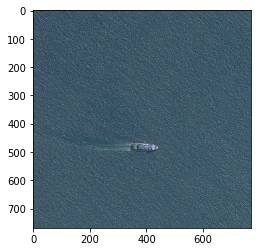

In [22]:
ds = imread(os.path.join(TRAIN_DIR, image_fps[0]))
plt.imshow(ds)

In [23]:
# Original image size: 768 x 768
ORIG_SIZE = ds.shape[0]
ORIG_SIZE

768

### Create and prepare the training dataset using the DetectorDataset class

In [24]:
%%time
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

CPU times: user 3min 24s, sys: 848 ms, total: 3min 25s
Wall time: 3min 25s


In [25]:
%%time
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

CPU times: user 7.96 s, sys: 16 ms, total: 7.98 s
Wall time: 7.98 s


### Display a random image with bounding boxes¶

In [28]:
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids)
    image_fp = dataset_val.image_reference(image_id)
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)


print(image.shape)
print(mask.shape)
print(class_ids)

(768, 768, 3)
(768, 768, 2)
[1 1]


./input/train_v2/76c8b155c.jpg
[1 1]


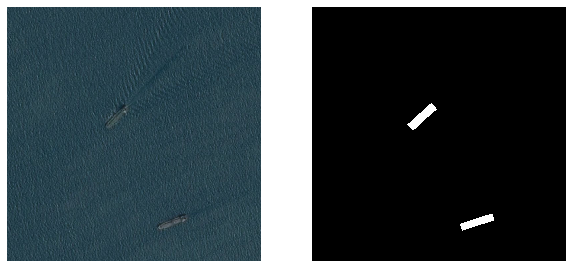

In [29]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += mask[:, :, i] ## * image[:, :, 0]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

In [58]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## rotate
        iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
        iaa.Affine(rotate=180),
        iaa.Affine(rotate=270),
    ]),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image, cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid.astype(int))

AttributeError: module 'numpy.random' has no attribute 'bit_generator'

### Now it's time to train the model. Note that training even a basic model can take a few hours

In [50]:
import warnings 
warnings.filterwarnings("ignore")

model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
# Exclude the last layers because they require a matching
# number of classes

model.load_weights(COCO_WEIGHTS, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [51]:
%%time

LEARNING_RATE = 0.003
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: ./airbus_segmentation20200201T1212/mask_rcnn_airbus_segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mas

In [64]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=20,
            layers='all',
            augmentation=None)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.003

Checkpoint Path: ./airbus_segmentation20200201T1212/mask_rcnn_airbus_segmentation_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bran

In [65]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,5.329279,1.718864,1.747216,0.278201,0.479366,1.105631,1.026076,0.210538,0.280693,0.075972,0.166507,0.292364
2,5.224894,1.690097,1.649146,0.277141,0.477864,1.130645,0.623284,0.084248,0.144124,0.057977,0.094698,0.242236
3,5.035965,1.782693,1.166657,0.501889,0.452327,1.132393,0.638920,0.058545,0.137673,0.078661,0.109090,0.254945
4,5.914603,2.629519,1.386275,0.519108,0.438745,0.940949,0.611008,0.073619,0.145904,0.072384,0.074828,0.244266
5,4.355841,1.696502,1.140166,0.557735,0.335942,0.625489,0.469154,0.031289,0.107832,0.058197,0.061331,0.210498
6,3.570985,0.683926,0.974629,0.535459,0.448392,0.928572,0.471564,0.038531,0.115987,0.054632,0.061376,0.201031
7,3.097741,0.534087,1.351494,0.117729,0.417664,0.676760,0.568398,0.066953,0.119927,0.095201,0.073935,0.212375
8,3.011256,0.581715,0.998905,0.082825,0.452081,0.895724,0.576810,0.029072,0.112300,0.060190,0.096191,0.279051
9,3.256344,1.130691,0.915435,0.100380,0.475448,0.634384,0.414648,0.043828,0.097085,0.028643,0.052512,0.192573
10,2.799884,0.674864,0.616190,0.411032,0.328565,0.769225,0.482293,0.047502,0.077928,0.074161,0.067460,0.215235


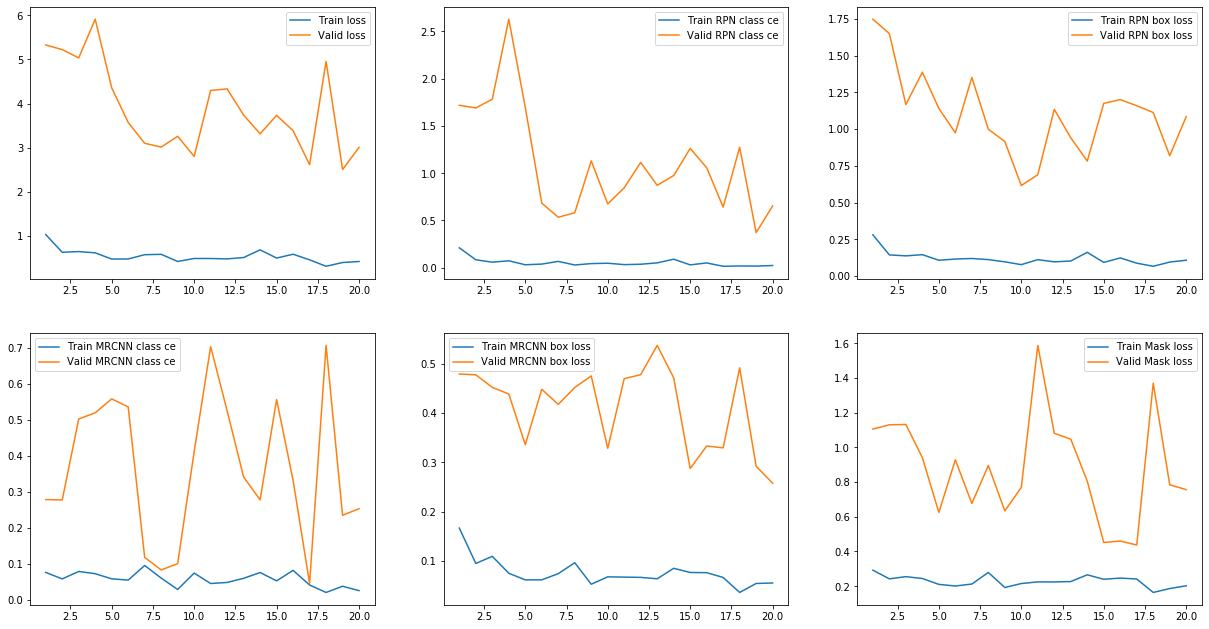

In [66]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [67]:
best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch:{best_epoch+1} val_loss:{score}')

Best Epoch:19 val_loss:2.501708414554596


In [76]:
dir_names = next(os.walk('./model'))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)
dir_names

['airbus_segmentation20200201T1212']

In [78]:
fps = []

for d in dir_names: 
    dir_name = os.path.join('./model', d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model ./model/airbus_segmentation20200201T1212/mask_rcnn_airbus_segmentation_0019.h5


In [134]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./model/airbus_segmentation20200201T1212/mask_rcnn_airbus_segmentation_0019.h5
Re-starting from epoch 19


In [90]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 



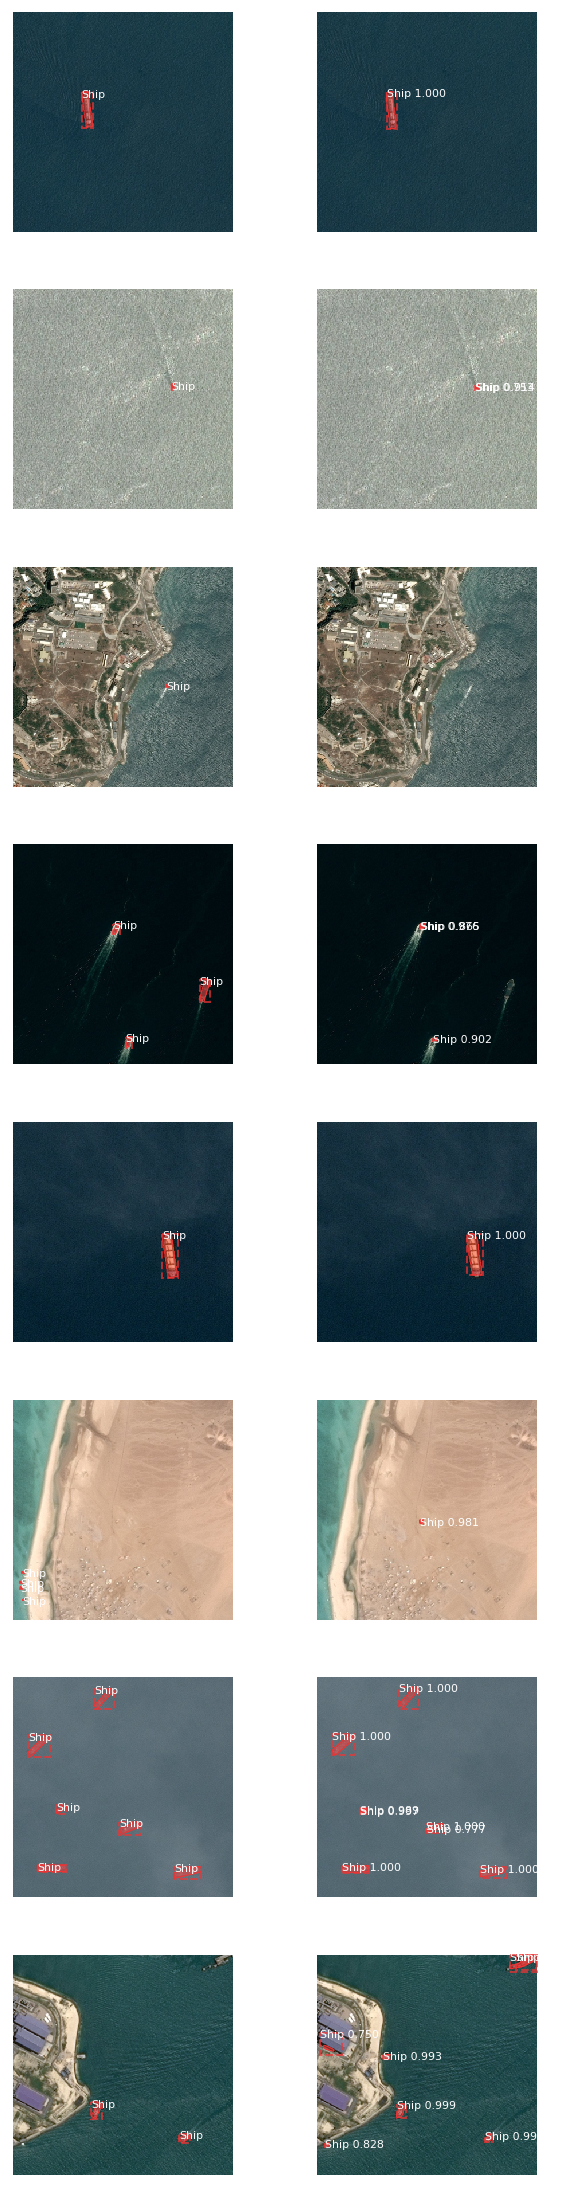

In [94]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(8):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
#     print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [135]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=config.DETECTION_MIN_CONFIDENCE):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("ImageId,EncodedPixels\n")

        for image_id in tqdm.tqdm(image_fps):
            found = False
            
            if len(image_id) != 0 :
                image = imread(os.path.join(TEST_DIR, image_id))
                # If grayscale. Convert to RGB for consistency.
                if len(image.shape) != 3 or image.shape[2] != 3:
                    image = np.stack((image,) * 3, -1)
#                 image, window, scale, padding, crop = utils.resize_image(
#                     image,
#                     min_dim=config.IMAGE_MIN_DIM,
#                     min_scale=config.IMAGE_MIN_SCALE,
#                     max_dim=config.IMAGE_MAX_DIM,
#                     mode=config.IMAGE_RESIZE_MODE)

                results = model.detect([image])
                r = results[0]

                assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
                if len(r['rois']) == 0:
                    pass  ## no ship
                else:
                    num_instances = len(r['rois'])

                    for i in range(num_instances):
                        if r['scores'][i] > min_conf:
#                             print(r['scores'][i], r['rois'][i], r['masks'].shape, np.sum(r['masks'][...,i]))
#                             plt.imshow(r['masks'][...,i], cmap=get_cmap('jet'))
                            file.write(image_id + "," + rle_encode(r['masks'][...,i]) + "\n")
                            found = True

            if not found:
                file.write(image_id + ",\n")  ## no ship

In [137]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)

100%|██████████| 15606/15606 [20:19<00:00, 12.80it/s]


In [138]:
sub = pd.read_csv(submission_fp)
print(sub.EncodedPixels.isnull().sum(), sub.ImageId.nunique(), sub.EncodedPixels.isnull().sum()/sub.ImageId.nunique())
sub.head(10)

10348 15606 0.6630783032167116


,ImageId,EncodedPixels
0,80663012d.jpg,NaN
1,93b6b965f.jpg,NaN
2,c13dfc8ac.jpg,299745 2 300512 5 301280 7 302048 7 302816 7 3...
3,c13dfc8ac.jpg,127639 6 128407 7 129175 8 129943 8 130711 8 1...
4,c13dfc8ac.jpg,40153 4 40921 6 41688 8 42456 8 43224 8 43992 ...
5,c13dfc8ac.jpg,316455 2 317223 6 317990 8 318759 7 319527 8 3...
6,c13dfc8ac.jpg,201362 4 202130 5 202898 5 203666 5 204434 5 2...
7,c13dfc8ac.jpg,216040 5 216808 6 217576 6 218344 6 219112 6 2...
8,c13dfc8ac.jpg,278868 3 279635 5 280403 5 281171 5 281939 5 2...
9,c13dfc8ac.jpg,163817 4 164584 7 165352 7 166121 7 166889 7 1...


In [142]:
# Get filenames of test dataset images
test_image_fps = test_names

DETECTION_TEST_PRED = './submission.csv'
ship_detection = pd.read_csv(DETECTION_TEST_PRED, index_col='ImageId')
ship_detection.head()

,EncodedPixels
ImageId,
80663012d.jpg,NaN
93b6b965f.jpg,NaN
c13dfc8ac.jpg,299745 2 300512 5 301280 7 302048 7 302816 7 3...
c13dfc8ac.jpg,127639 6 128407 7 129175 8 129943 8 130711 8 1...
c13dfc8ac.jpg,40153 4 40921 6 41688 8 42456 8 43224 8 43992 ...
